In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import awkward as ak
import numpy as np
import boost_histogram as bh

from coffea.nanoevents import NanoEventsFactory, BaseSchema

import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)

import awkward as ak

In [3]:
# Load events
'''
events = NanoEventsFactory.from_root(
    '/home/users/hbronson/CMSSW_11_3_1_patch1/src/Phase2Timing/ntuple_phase2timing0mm.root',
    schemaclass = BaseSchema,
    treepath='demo/tree',
    entry_stop = 1000).events()
'''
# Load events
events = NanoEventsFactory.from_root(
    '/home/users/dspitzba/timing/CMSSW_11_3_1_patch1/src/Phase2Timing/ntuple_phase2timing1000mm.root',
    schemaclass = BaseSchema,
    treepath='demo/tree',
    entry_stop = 1000).events()

In [4]:
etl_eta = events['gp_eta_etl_hits']
etl_phi = events['gp_phi_etl_hits']

btl_eta = events['gp_eta_btl_hits']
btl_phi = events['gp_phi_btl_hits']

mtd_eta_hits = ak.concatenate((btl_eta, etl_eta), axis = 1)
mtd_phi_hits = ak.concatenate((btl_phi, etl_phi), axis = 1)

reco_pho_eta = events['reco_photon_eta']
reco_pho_phi = events['reco_photon_phi']

#electrons, but all of these give the same thing
reco_ele_eta = events['e_eta']
reco_ele_phi = events['e_phi']

gen_ele_eta = events['e_ebeta']
gen_ele_phi = events['e_ebphi']

gen_ele_eta1 = events['e_hgeta']
gen_ele_phi1 = events['e_hgphi']

#electorn cut for eta<3.1
reco_ele_eta = reco_ele_eta[abs(reco_ele_eta) < 3.1]
reco_ele_phi = reco_ele_phi[abs(reco_ele_eta) < 3.1]

track_eta = events['track_eta']
track_phi = events['track_phi']

#pt cut for tracks
track_pt = events['track_pt'] 
pt_5_cut = track_pt > 5
track_eta_w_cut = track_eta[pt_5_cut]
track_phi_w_cut = track_phi[pt_5_cut]

#times
btl_times = events['gp_time_btl_hits']
etl_times = events['gp_time_etl_hits']

eb_delay = events['e_ebdelay']
hg_delay = events['e_hgdelay']
barrel_eta_cut = abs(reco_ele_eta) < 1.48

ele_delay_times = (ak.concatenate([eb_delay[barrel_eta_cut],hg_delay[~barrel_eta_cut]], axis = 1))
mtd_times = (ak.concatenate([btl_times, etl_times], axis = 1))

btl_energy = events['gp_energy_btl_hits']
etl_energy = events['gp_energy_etl_hits']
mtd_energy = ak.concatenate((btl_energy, etl_energy), axis=1)

ele_pt = events['e_pt']

#these are in cm
bx = events['gp_x_btl_hits']
ex = events['gp_x_etl_hits']
by = events['gp_y_btl_hits']
ey = events['gp_y_etl_hits']
bz = events['gp_z_btl_hits']
ez = events['gp_z_etl_hits']

In [5]:
#calc the time delay, subtract from plot time the time from origin to hit 
v = 29.9792458 

min_etl_times = []
min_btl_times = []

for i in range(len(etl_eta)):
    min_etl_times.append( (abs( ex[i]**2 + ey[i]**2 + ez[i]**2 )**0.5)/ v)
    min_btl_times.append( (abs( bx[i]**2 + by[i]**2 + bz[i]**2 )**0.5) / v)
    
btl_time_diff = np.subtract(btl_times, min_btl_times)
etl_time_diff = np.subtract(etl_times, min_etl_times)
    
mtd_delays = ak.concatenate([btl_time_diff, etl_time_diff], axis=1) 

time_bins = np.linspace(-5, 25, 31)

In [6]:
#finds overlaps of photons and eles
r2_val = 0.01
overlaps_eta = []
overlaps_phi = []
overlaps_delay = []

for i in range(len(reco_pho_phi)): #for each event
    tmp_eta = []
    tmp_phi = []
    tmp_time = []
    if len(reco_pho_phi[i]) <= len(reco_ele_phi[i]):
        for j in range(len(reco_pho_phi[i])): #loops through the photons
            for k in range(len(reco_ele_phi[i])): #loops through the eles
                if ((reco_pho_phi[i][j] - reco_ele_phi[i][k])**2 + (reco_pho_eta[i][j] - reco_ele_eta[i][k])**2) < r2_val:
                    tmp_eta.append(reco_ele_eta[i][k])
                    tmp_phi.append(reco_ele_phi[i][k])
                    tmp_time.append(ele_delay_times[i][k])
        overlaps_eta.append(tmp_eta)
        overlaps_phi.append(tmp_phi)
        overlaps_delay.append(tmp_time)
    else:
        for j in range(len(reco_ele_phi[i])):
            for k in range(len(reco_pho_phi[i])):
                if ((reco_ele_phi[i][j] - reco_pho_phi[i][k])**2 + (reco_ele_eta[i][j] - reco_pho_eta[i][k])**2) < r2_val:
                    tmp_eta.append(reco_ele_eta[i][j])
                    tmp_phi.append(reco_ele_phi[i][j])
                    tmp_time.append(ele_delay_times[i][j])
        overlaps_eta.append(tmp_eta)
        overlaps_phi.append(tmp_phi)
        overlaps_delay.append(tmp_time)

In [10]:
#finds mtd hits within an r = sqrt(r2_val) of the electron and photon
#r2_val = 0.4**2
mtd_matches_eta = []
mtd_matches_phi = []
mtd_matches_time = []
mtd_matches_time_1ns = []
mtd_matches_delays = []
mtd_matches_delays_1ns = []
mtd_matches_energy = []

for i in range(len(mtd_eta_hits)): #loops through each event 
    tmp_eta = []
    tmp_phi = []
    tmp_times = []
    tmp_times_1ns = []
    tmp_delays = []
    tmp_delays_1ns = []    
    tmp_energy = []
    
    tmp2_eta = []
    tmp2_phi = []
    tmp2_times = []
    tmp2_times_1ns = []
    tmp2_delays = []
    tmp2_delays_1ns = []    
    tmp2_energy = []
    
    
    for j in range(len(overlaps_eta[i])): #loops through each overlap
        for k in range(len(mtd_eta_hits[i])): #loops through each hit
            if ((mtd_eta_hits[i][k] - overlaps_eta[i][j])**2 + (mtd_phi_hits[i][k] - overlaps_phi[i][j])**2) < r2_val:
                
                if overlaps_delay[i][j] > 1e-9: #999: 
                    #print('hello', i, j, overlaps_delay[i][j])
                    tmp_times_1ns.append(mtd_times[i][k])
                    tmp_delays_1ns.append(mtd_delays[i][k])
                    
                tmp_eta.append(mtd_eta_hits[i][k])
                tmp_phi.append(mtd_phi_hits[i][k])
                tmp_times.append(mtd_times[i][k])
                tmp_delays.append(mtd_delays[i][k])
                tmp_energy.append(mtd_energy[i][k]) 

        tmp2_eta.append(tmp_eta) 
        tmp2_phi.append(tmp_phi)
        tmp2_times.append(tmp_times)
        tmp2_times_1ns.append(tmp_times_1ns)
        tmp2_delays.append(tmp_delays) 
        tmp2_delays_1ns.append(tmp_delays_1ns)  
        tmp2_energy.append(tmp_energy)
          
        tmp_eta = []
        tmp_phi = []
        tmp_times = []
        tmp_times_1ns = []
        tmp_delays = []
        tmp_delays_1ns = []    
        tmp_energy = []
        
    mtd_matches_eta.append((tmp2_eta))
    mtd_matches_phi.append((tmp2_phi))
    mtd_matches_time.append((tmp2_times))
    mtd_matches_time_1ns.append((tmp2_times_1ns))
    mtd_matches_delays.append((tmp2_delays))
    mtd_matches_delays_1ns.append((tmp2_delays_1ns))
    mtd_matches_energy.append((tmp2_energy))
    

hello 15 1 1000.0
hello 15 1 1000.0
hello 15 1 1000.0
hello 15 1 1000.0
hello 15 1 1000.0
hello 45 0 1000.0
hello 45 0 1000.0
hello 45 0 1000.0
hello 45 0 1000.0
hello 45 0 1000.0
hello 45 0 1000.0
hello 45 0 1000.0
hello 45 0 1000.0
hello 46 0 1000.0
hello 46 0 1000.0
hello 46 0 1000.0
hello 46 0 1000.0
hello 46 0 1000.0
hello 46 0 1000.0
hello 46 0 1000.0
hello 46 0 1000.0
hello 46 0 1000.0
hello 46 0 1000.0
hello 149 2 1000.0
hello 149 2 1000.0
hello 155 0 1000.0
hello 155 0 1000.0
hello 155 0 1000.0
hello 155 0 1000.0
hello 155 0 1000.0
hello 155 0 1000.0
hello 155 0 1000.0
hello 155 0 1000.0
hello 155 0 1000.0
hello 155 0 1000.0
hello 155 0 1000.0
hello 155 0 1000.0
hello 155 0 1000.0
hello 155 0 1000.0
hello 155 0 1000.0
hello 155 0 1000.0
hello 155 0 1000.0
hello 161 1 5.720294460331843e-09
hello 161 1 5.720294460331843e-09
hello 161 1 5.720294460331843e-09
hello 180 0 1.2785374536861127e-08
hello 180 0 1.2785374536861127e-08
hello 180 0 1.2785374536861127e-08
hello 180 0 1.2785

In [30]:
num_pho_match = []

for i in range(len(mtd_matches_eta)):
    num_pho_match.append(ak.num(mtd_matches_eta[i]))

overlaps_eta = ak.Array(overlaps_eta)
ele_pt_of_matches = ele_pt

btl_ele_pt = ele_pt_of_matches[abs(overlaps_eta)<1.5]
etl_ele_pt = ele_pt_of_matches[abs(overlaps_eta)>=1.5]

num_pho_match = ak.Array(num_pho_match)

num_mtd_pho_hits_btl = num_pho_match[abs(overlaps_eta)<1.5]  
num_mtd_pho_hits_etl = num_pho_match[abs(overlaps_eta)>=1.5] 

In [31]:
btl_eff = []
etl_eff = []

btl_total_hits = (ak.num(btl_eta))
etl_total_hits = (ak.num(etl_eta))

for i in range(len(btl_total_hits)):
    for j in range(len(num_mtd_pho_hits_btl[i])):
        btl_eff.append(num_mtd_pho_hits_btl[i][j]/btl_total_hits[i])
    for k in range(len(num_mtd_pho_hits_etl[i])):
        etl_eff.append(num_mtd_pho_hits_etl[i][k]/etl_total_hits[i])

In [32]:
mtd_matches_energy = ak.Array(mtd_matches_energy)

btl_matches_energy = mtd_matches_energy[abs(overlaps_eta)<1.5]
etl_matches_energy = mtd_matches_energy[abs(overlaps_eta)>=1.5]

mtd_times = ak.Array(mtd_times)
btl_matches_time = mtd_times[abs(overlaps_eta)<1.5]
etl_matches_time = mtd_times[overlaps_eta>=1.5]

In [33]:
mtd_matches_time = ak.Array(mtd_matches_time)
mtd_matches_energy = ak.Array(mtd_matches_energy)
mtd_matches_eta = ak.Array(mtd_matches_eta)

btl_energy_matches = mtd_matches_energy[abs(mtd_matches_eta)<1.5]
etl_energy_matches = mtd_matches_energy[abs(mtd_matches_eta)>=1.5]
btl_time_matches = mtd_matches_time[abs(mtd_matches_eta)<1.5]
etl_time_matches = mtd_matches_time[abs(mtd_matches_eta)>=1.5]

In [34]:
flat_overlaps_eta = ak.flatten(overlaps_eta)
flat_overlaps_phi = ak.flatten(overlaps_phi)
flat_mtd_eta = ak.copy(ak.flatten(mtd_matches_eta))
flat_mtd_phi = ak.flatten(mtd_matches_phi)
flat_mtd_delay = ak.flatten(mtd_matches_delays)
closest_delay = []
closest_2delays = []
tmp = []

for i in range(len(flat_overlaps_eta)):
    if len(flat_mtd_eta[i]) > 0:
        closest = ak.argmin((flat_mtd_eta[i]-flat_overlaps_eta[i])**2+(flat_mtd_phi[i]-flat_overlaps_phi[i])**2)
        if len(flat_mtd_eta[i]) > 1:
            np.asarray(flat_mtd_eta[i])[closest] = -999
            closest_2 = ak.argmin((flat_mtd_eta[i]-flat_overlaps_eta[i])**2+(flat_mtd_phi[i]-flat_overlaps_phi[i])**2)
            closest_2delays.append(flat_mtd_delay[i][closest])
            closest_2delays.append(flat_mtd_delay[i][closest_2])
            
        closest_delay.append(flat_mtd_delay[i][closest])
        
        

## Plotting

In [27]:
ele_delay_times_0 = ele_delay_times
mtd_matches_time_0 = mtd_matches_time 
mtd_matches_time_1ns_0 = mtd_matches_time_1ns
mtd_matches_delays_0 = mtd_matches_delays 
mtd_matches_delays_1ns_0 = mtd_matches_delays_1ns 
closest_delay_0 = closest_delay
closest_2delays_0 = closest_2delays

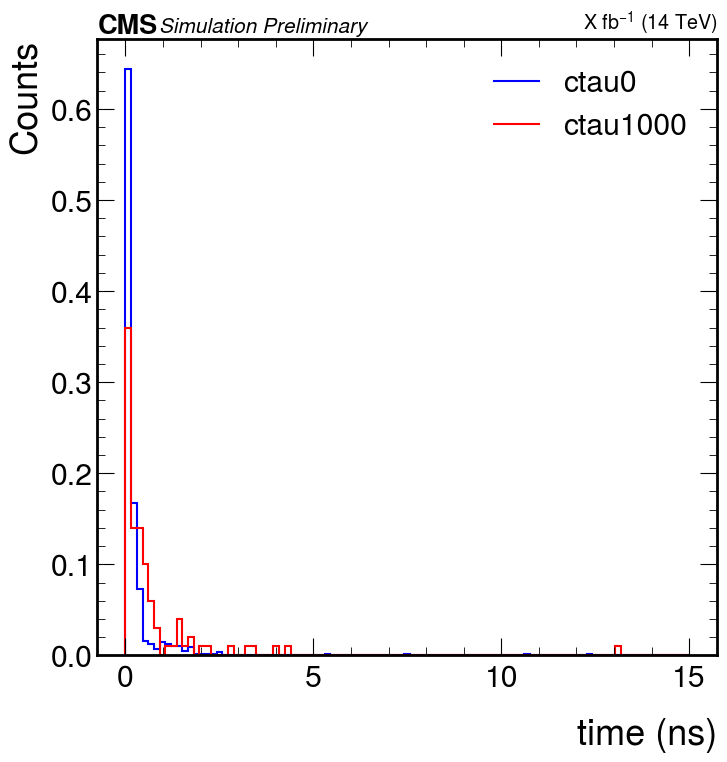

In [55]:
#plots delays for the closest 1 mtd hit that overlap with photon/ele 

time_bins = np.linspace(0, 15, 100)
ctau0_time_hist = np.histogram(np.clip(closest_delay_0, time_bins[0], time_bins[-1]), bins=time_bins)
ctau1000_time_hist = np.histogram(np.clip(closest_delay, time_bins[0], time_bins[-1]), bins=time_bins)

f, ax = plt.subplots(figsize=(8, 8))

hep.histplot(
    ctau0_time_hist[0]/(ak.sum(ctau0_time_hist[0])),
    time_bins,
    histtype="step",
    stack=False,
    label=['ctau0'],
    color=['blue'],
    ax=ax,
    )

hep.histplot(
    ctau1000_time_hist[0]/(ak.sum(ctau1000_time_hist[0])),
    time_bins,
    histtype="step",
    stack=False,
    label=['ctau1000'],
    color=['red'],
    ax=ax,
    )

hep.cms.label(
    "Preliminary",
    data=False,
    lumi='X',
    com=14,
    loc=0,
    ax=ax,
    fontsize=15,
)

ax.set_ylabel('Counts')
ax.set_xlabel('time (ns)')
ax.xaxis.set_label_coords(1, -.1)


plt.legend()

#f.savefig('/home/users/hbronson/public_html/delayed_electrons/01r/MTD_matches_delays_closest1_normalized.png')


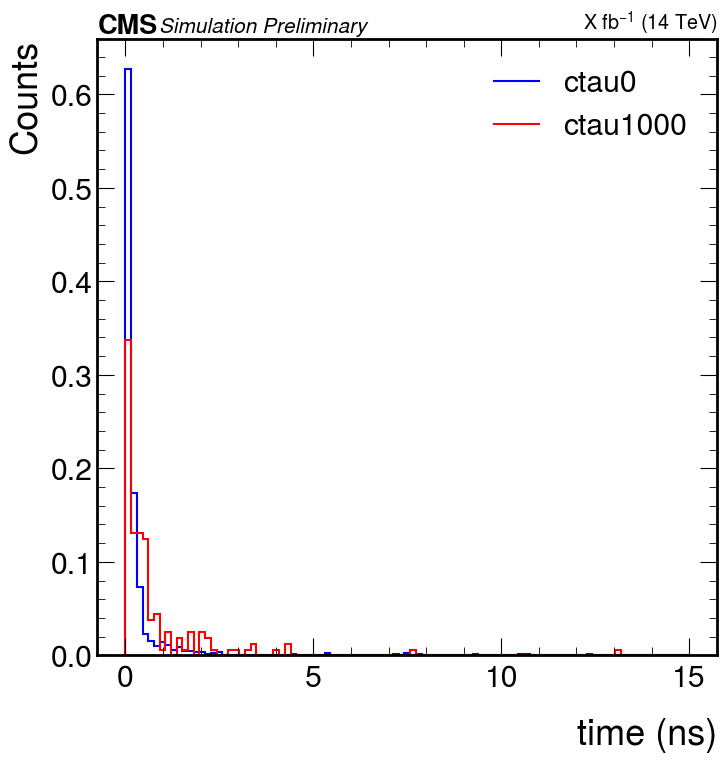

In [56]:
#plots delays for the closest 2 mtd hit that overlap with photon/ele 

time_bins = np.linspace(0, 15, 100)
ctau0_time_hist = np.histogram(np.clip(closest_2delays_0, time_bins[0], time_bins[-1]), bins=time_bins)
ctau1000_time_hist = np.histogram(np.clip(closest_2delays, time_bins[0], time_bins[-1]), bins=time_bins)


f, ax = plt.subplots(figsize=(8, 8))

hep.histplot(
    ctau0_time_hist[0]/(ak.sum(ctau0_time_hist[0])),
    time_bins,
    histtype="step",
    stack=False,
    label=['ctau0'],
    color=['blue'],
    ax=ax,
    )

hep.histplot(
    ctau1000_time_hist[0]/(ak.sum(ctau1000_time_hist[0])),
    time_bins,
    histtype="step",
    stack=False,
    label=['ctau1000'],
    color=['red'],
    ax=ax,
    )

hep.cms.label(
    "Preliminary",
    data=False,
    lumi='X',
    com=14,
    loc=0,
    ax=ax,
    fontsize=15,
)

ax.set_ylabel('Counts')
ax.set_xlabel('time (ns)')
ax.xaxis.set_label_coords(1, -.1)


plt.legend()

#f.savefig('/home/users/hbronson/public_html/delayed_electrons/01r/MTD_matches_delays_closest2_normalized.png')


In [ ]:
#plots the time delays for eb and hg
ele_delay_times_0_ns = ele_delay_times_0 * 1e9
ele_delay_times_ns = ele_delay_times * 1e9

time_bins = np.linspace(0, 10, 100)

ctau0_hgeb_hist = np.histogram(np.clip(ak.flatten(ele_delay_times_0_ns), time_bins[0], time_bins[-1]), bins=time_bins)
ctau1000_hgeb_hist = np.histogram(np.clip(ak.flatten(ele_delay_times_ns), time_bins[0], time_bins[-1]), bins=time_bins)


f, ax = plt.subplots(figsize=(8, 8))

hep.histplot(
    ctau0_hgeb_hist[0],
    time_bins,
    histtype="step",
    stack=False,
    label=['ctau0'],
    color=['blue'],
    ax=ax,
    )

hep.histplot(
    ctau1000_hgeb_hist[0],
    time_bins,
    histtype="step",
    stack=False,
    label=['ctau1000'],
    color=['red'],
    ax=ax,
    )

hep.cms.label(
    "Preliminary",
    data=False,
    lumi='X',
    com=14,
    loc=0,
    ax=ax,
    fontsize=15,
)

ax.set_ylabel('Counts')
ax.set_xlabel('time (ns)')
ax.xaxis.set_label_coords(1, -.1)

plt.legend()

#f.savefig('/home/users/hbronson/public_html/delayed_electrons/hg_eb_delay/ctau0_ctau1000.png')

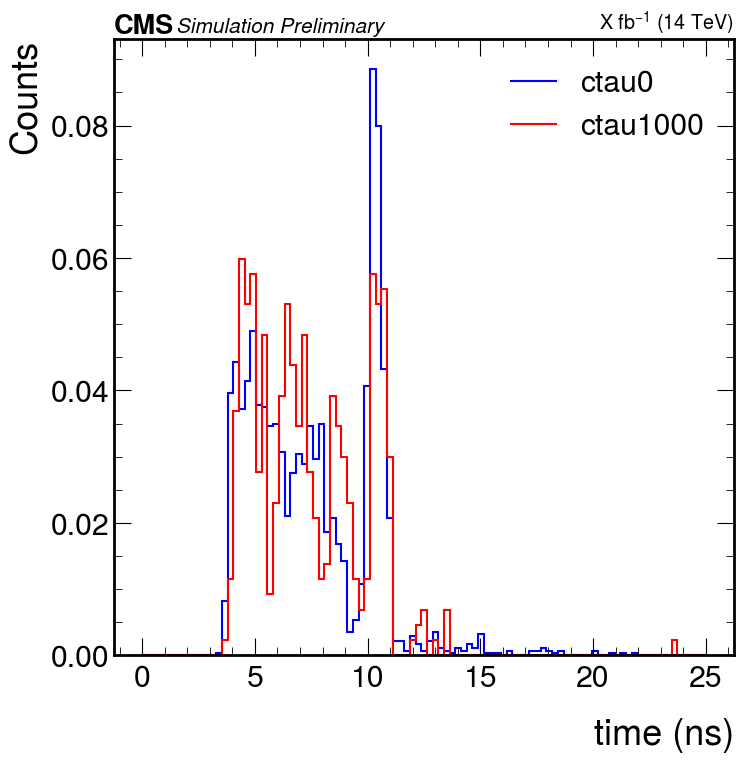

In [59]:
#plots times for mtd hits that overlap with photon/ele 

time_bins = np.linspace(0, 25, 100)
ctau0_time_hist = np.histogram(np.clip(ak.flatten(ak.flatten(mtd_matches_time_0)), time_bins[0], time_bins[-1]), bins=time_bins)
ctau1000_time_hist = np.histogram(np.clip(ak.flatten(ak.flatten(mtd_matches_time)), time_bins[0], time_bins[-1]), bins=time_bins)


f, ax = plt.subplots(figsize=(8, 8))

hep.histplot(
    ctau0_time_hist[0]/(ak.sum(ctau0_time_hist[0])),
    time_bins,
    histtype="step",
    stack=False,
    label=['ctau0'],
    color=['blue'],
    ax=ax,
    )

hep.histplot(
    ctau1000_time_hist[0]/(ak.sum(ctau1000_time_hist[0])),
    time_bins,
    histtype="step",
    stack=False,
    label=['ctau1000'],
    color=['red'],
    ax=ax,
    )

hep.cms.label(
    "Preliminary",
    data=False,
    lumi='X',
    com=14,
    loc=0,
    ax=ax,
    fontsize=15,
)

ax.set_ylabel('Counts')
ax.set_xlabel('time (ns)')
ax.xaxis.set_label_coords(1, -.1)


plt.legend()

#f.savefig('/home/users/hbronson/public_html/delayed_electrons/01r/MTD_times_v2_norm.png')


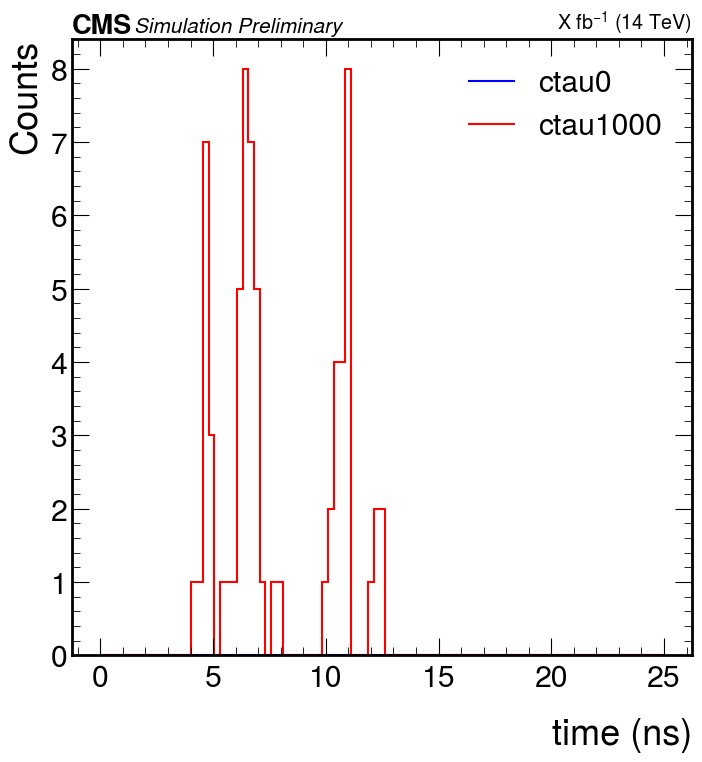

In [60]:
#plots times for mtd hits that overlap with photon/ele w/ an ele delay time>1ns

time_bins = np.linspace(0, 25, 100)
ctau0_time_hist = np.histogram(np.clip(ak.flatten(ak.flatten(mtd_matches_time_1ns_0)), time_bins[0], time_bins[-1]), bins=time_bins)
ctau1000_time_hist = np.histogram(np.clip(ak.flatten(ak.flatten(mtd_matches_time_1ns)), time_bins[0], time_bins[-1]), bins=time_bins)


f, ax = plt.subplots(figsize=(8, 8))

hep.histplot(
    ctau0_time_hist[0],
    time_bins,
    histtype="step",
    stack=False,
    label=['ctau0'],
    color=['blue'],
    ax=ax,
    )

hep.histplot(
    ctau1000_time_hist[0],
    time_bins,
    histtype="step",
    stack=False,
    label=['ctau1000'],
    color=['red'],
    ax=ax,
    )

hep.cms.label(
    "Preliminary",
    data=False,
    lumi='X',
    com=14,
    loc=0,
    ax=ax,
    fontsize=15,
)

ax.set_ylabel('Counts')
ax.set_xlabel('time (ns)')
ax.xaxis.set_label_coords(1, -.1)


plt.legend()

#f.savefig('/home/users/hbronson/public_html/delayed_electrons/01r/MTD_times_wdelay>1ns_v2.png')


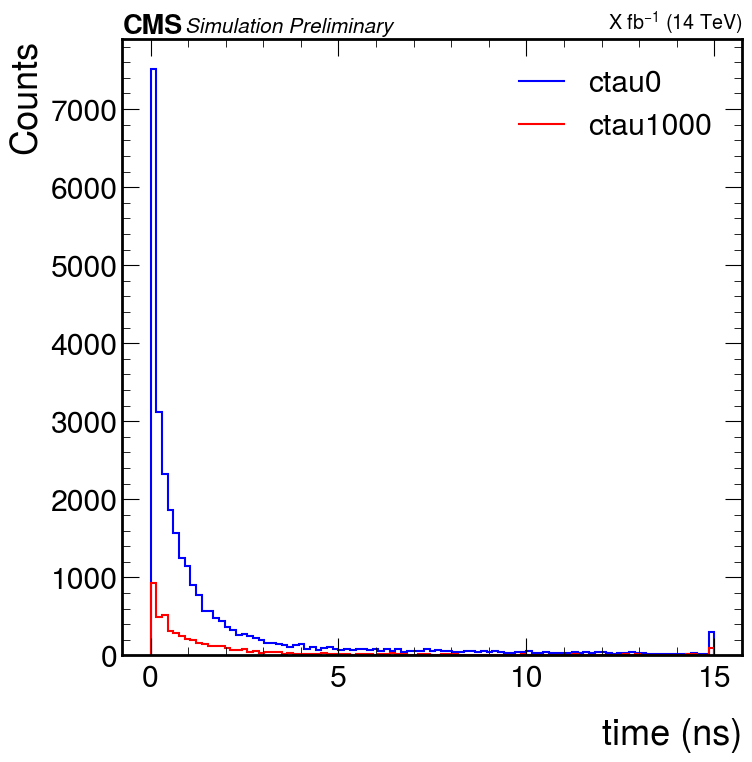

In [24]:
#plots delays for mtd hits that overlap with photon/ele 

time_bins = np.linspace(0, 15, 100)
ctau0_time_hist = np.histogram(np.clip(ak.flatten(ak.flatten(mtd_matches_delays_0)), time_bins[0], time_bins[-1]), bins=time_bins)
ctau1000_time_hist = np.histogram(np.clip(ak.flatten(ak.flatten(mtd_matches_delays)), time_bins[0], time_bins[-1]), bins=time_bins)


f, ax = plt.subplots(figsize=(8, 8))

hep.histplot(
    ctau0_time_hist[0], #/(ak.sum(ctau0_time_hist[0])),
    time_bins,
    histtype="step",
    stack=False,
    label=['ctau0'],
    color=['blue'],
    ax=ax,
    )

hep.histplot(
    ctau1000_time_hist[0], #/(ak.sum(ctau1000_time_hist[0])),
    time_bins,
    histtype="step",
    stack=False,
    label=['ctau1000'],
    color=['red'],
    ax=ax,
    )

hep.cms.label(
    "Preliminary",
    data=False,
    lumi='X',
    com=14,
    loc=0,
    ax=ax,
    fontsize=15,
)

ax.set_ylabel('Counts')
ax.set_xlabel('time (ns)')
ax.xaxis.set_label_coords(1, -.1)


plt.legend()

#f.savefig('/home/users/hbronson/public_html/delayed_electrons/01r/MTD_matches_delays_deltar1.png')


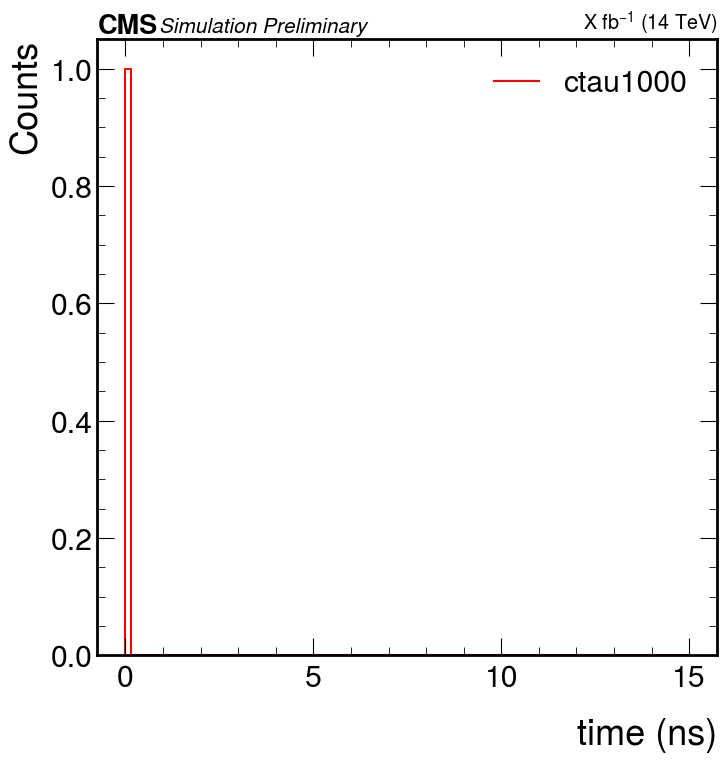

In [68]:
#plots delays for mtd hits that overlap with photon/ele w/ an ele delay time>1ns

time_bins = np.linspace(0, 15, 100)
ctau0_time_hist = np.histogram(np.clip(ak.flatten(ak.flatten(mtd_matches_delays_1ns_0)), time_bins[0], time_bins[-1]), bins=time_bins)
ctau1000_time_hist = np.histogram(np.clip(ak.flatten(ak.flatten(mtd_matches_delays_1ns)), time_bins[0], time_bins[-1]), bins=time_bins)

'''ctau45 = np.histogram(np.clip(((mtd_matches_delays_1ns[45])), time_bins[0], time_bins[-1]), bins=time_bins)
ctau46 = np.histogram(np.clip(((mtd_matches_delays_1ns[46])), time_bins[0], time_bins[-1]), bins=time_bins)
ctau149 = np.histogram(np.clip((ak.flatten(mtd_matches_delays_1ns[149])), time_bins[0], time_bins[-1]), bins=time_bins)
ctau155 = np.histogram(np.clip(((mtd_matches_delays_1ns[155])), time_bins[0], time_bins[-1]), bins=time_bins)
ctau161 = np.histogram(np.clip((ak.flatten(mtd_matches_delays_1ns[161])), time_bins[0], time_bins[-1]), bins=time_bins)
ctau180 = np.histogram(np.clip(((mtd_matches_delays_1ns[180])), time_bins[0], time_bins[-1]), bins=time_bins)
#45, 46, 149, 155,, 161, 180'''

f, ax = plt.subplots(figsize=(8, 8))

hep.histplot(
    ctau0_time_hist[0],
    time_bins,
    histtype="step",
    stack=False,
    label=['ctau0'],
    color=['blue'],
    ax=ax,
    )

hep.histplot(
    ctau1000_time_hist[0],
    time_bins,
    histtype="step",
    stack=False,
    label=['ctau1000'],
    color=['red'],
    ax=ax,
    )

'''hep.histplot(
    ctau149[0],
    time_bins,
    histtype="step",
    stack=False,
    label=['ctau1000'],
    color=['red'],
    ax=ax,
    )'''

hep.cms.label(
    "Preliminary",
    data=False,
    lumi='X',
    com=14,
    loc=0,
    ax=ax,
    fontsize=15,
)

ax.set_ylabel('Counts')
ax.set_xlabel('time (ns)')
ax.xaxis.set_label_coords(1, -.1)


plt.legend()

#f.savefig('/home/users/hbronson/public_html/delayed_electrons/01r/MTD_matches_delays_v2.png')
#f.savefig('/home/users/hbronson/public_html/delayed_electrons/01r/MTD_matches_delays_5ns_ev149.png')
#f.savefig('/home/users/hbronson/public_html/delayed_electrons/01r/MTD_matches_delays_10ns.png')



In [ ]:
f, ax = plt.subplots(figsize=(8, 8))
    
plt.scatter(ak.flatten(ak.flatten(btl_time_matches)), ak.flatten(ak.flatten(btl_energy_matches)), color='b', marker='.', label='btl')
plt.scatter(ak.flatten(ak.flatten(etl_time_matches)), ak.flatten(ak.flatten(etl_energy_matches)), color='r', marker='.', label='etl')
    
hep.cms.label(
    "Preliminary",
    data=False,
    #lumi='X',
    com=14,
    loc=0,
    ax=ax,
    fontsize=15,
)

ax.set_ylabel('Energy (GeV)')
ax.set_xlabel('time')
ax.xaxis.set_label_coords(1, -.1)

plt.legend()
#f.savefig('/home/users/hbronson/public_html/delayed_electrons/01r/E_vs_t_v2.png')

In [ ]:
f, ax = plt.subplots(figsize=(8, 8))
    
plt.scatter(ak.flatten(btl_ele_pt), btl_eff, color='b', marker='.', label='btl eff')
plt.scatter(ak.flatten(etl_ele_pt), etl_eff, color='r', marker='.', label='etl eff')
    

hep.cms.label(
    "Preliminary",
    data=False,
    #lumi='X',
    com=14,
    loc=0,
    ax=ax,
    fontsize=15,
)

ax.set_ylabel('Efficiency')
ax.set_xlabel('pt')
ax.xaxis.set_label_coords(1, -.1)

plt.legend()
#f.savefig('/home/users/hbronson/public_html/delayed_electrons/01r/btletl_eff.png')

In [ ]:
#plots number of matched mtd hits
time_bins = np.linspace(0, 50, 51)

etl_matches_hist = np.histogram(ak.flatten(num_mtd_pho_hits_etl), bins=time_bins)
btl_matches_hist = np.histogram(ak.flatten(num_mtd_pho_hits_btl), bins=time_bins)
both_matches_hist = np.histogram(ak.flatten(num_pho_match), bins=time_bins)

f, ax = plt.subplots(figsize=(8, 8))

hep.histplot(
    etl_matches_hist[0],
    time_bins,
    histtype="step",
    stack=False,
    label=['etl'],
    color=['red'],
    ax=ax,
    )
    
hep.cms.label(
    "Preliminary",
    data=False,
    lumi='X',
    com=14,
    loc=0,
    ax=ax,
    fontsize=15,
)

ax.set_ylabel('# of photons')
ax.set_xlabel('Counts of matches')
ax.xaxis.set_label_coords(1, -.1)

plt.legend()
#f.savefig('/home/users/hbronson/public_html/delayed_electrons/01r/num_etl_mtd_matches_v2.png')



##################3
f, ax = plt.subplots(figsize=(8, 8))

hep.histplot(
    btl_matches_hist[0],
    time_bins,
    histtype="step",
    stack=False,
    label=['btl'],
    color=['blue'],
    ax=ax,
    )
    
hep.cms.label(
    "Preliminary",
    data=False,
    lumi='X',
    com=14,
    loc=0,
    ax=ax,
    fontsize=15,
)

ax.set_ylabel('# of photons')
ax.set_xlabel('Counts of matches')
ax.xaxis.set_label_coords(1, -.1)

plt.legend()
#f.savefig('/home/users/hbronson/public_html/delayed_electrons/01r/num_btl_mtd_matches_v2.png')

###############
f, ax = plt.subplots(figsize=(8, 8))

hep.histplot(
    both_matches_hist[0],
    time_bins,
    histtype="step",
    stack=False,
    label=['etl and btl'],
    color=['red'],
    ax=ax,
    )


hep.cms.label(
    "Preliminary",
    data=False,
    lumi='X',
    com=14,
    loc=0,
    ax=ax,
    fontsize=15,
)

ax.set_ylabel('# of photons')
ax.set_xlabel('Counts of matches')
ax.xaxis.set_label_coords(1, -.1)


plt.legend()

#f.savefig('/home/users/hbronson/public_html/delayed_electrons/01r/num_btletl_mtd_matches_v2.png')

In [ ]:
#plots the photons and electrons overlaps, plots the mtd hits that are close
for i in range(len(reco_pho_phi)):
    f, ax = plt.subplots(figsize=(8, 8))
 
    #plt.scatter(overlaps_phi[i], overlaps_eta[i], color='m', marker='s', s=50, label='photon/ele')
    plt.scatter(ak.flatten(mtd_matches_phi[i]), ak.flatten(mtd_matches_eta[i]), color='b', marker='.', label='r<.1')
    
    for j in range(len(overlaps_phi[i])):
        circle = plt.Circle((overlaps_phi[i][j], overlaps_eta[i][j]), 0.1, fill = False )
        ax.set_aspect(1)
        ax.add_artist(circle)
        
    plt.axhline(y=1.5, color='gray', linestyle='--')
    plt.axhline(y=-1.5, color='gray', linestyle='--')

    
    hep.cms.label(
        "Preliminary",
        data=False,
        #lumi='X',
        com=14,
        loc=0,
        ax=ax,
        fontsize=15,
    )

    ax.set_xlabel(r'$\phi$')
    ax.set_ylabel(r'$\eta$')
    plt.legend(frameon=True, loc=2, prop={'size': 7})
    plt.xlim([-3.1, 3.1])
    plt.ylim([-4, 4])
    plt.show()
    #f.savefig('/home/users/hbronson/public_html/delayed_electrons/01r/event' + str(i) + '.png')
    print("saving fig " + str(i) + " now")
    

In [ ]:
#eta&phi plots with no cuts
for i in range(len(etl_phi)):
    f, ax = plt.subplots(figsize=(8, 8))

    plt.scatter(reco_pho_phi[i], reco_pho_eta[i], color='m', marker='s', s=50, label='reco photon')
    plt.scatter(reco_ele_phi[i], reco_ele_eta[i], color='c', marker='P', s=50, label='electron')
    #plt.scatter(gen_ele_phi[i], gen_ele_eta[i], color='g', marker='X', s=100, label='gen electron')
    plt.scatter(etl_phi[i], etl_eta[i], color='b', marker='.', label='ETL')
    plt.scatter(btl_phi[i], btl_eta[i], color='b', marker='.', label='BTL')
    plt.scatter(track_phi[i], track_eta[i], facecolors='none', edgecolors='r', s=50, label='tracks')
    
    plt.axhline(y=1.5, color='gray', linestyle='--')
    plt.axhline(y=-1.5, color='gray', linestyle='--')


    hep.cms.label(
        "Preliminary",
        data=False,
        #lumi='X',
        com=14,
        loc=0,
        ax=ax,
        fontsize=15,
    )

    ax.set_xlabel(r'$\phi$')
    ax.set_ylabel(r'$\eta$')
    plt.legend(frameon=True, loc=2, prop={'size': 7})
    plt.show()
    #f.savefig('/home/users/hbronson/public_html/delayed_electrons/test/event' + str(i) + '.png')
    print("saving fig " + str(i) + " now")


In [ ]:
#plots with track pt cut > 5
for i in range(len(etl_phi)):
    f, ax = plt.subplots(figsize=(8, 8))
    
    plt.scatter(reco_pho_phi[i], reco_pho_eta[i], color='m', marker='s', s=50, label='reco photon')
    plt.scatter(reco_ele_phi[i], reco_ele_eta[i], color='c', marker='P', s=50, label='electron')
    #plt.scatter(gen_ele_phi[i], gen_ele_eta[i], color='g', marker='X', s=100, label='gen electron')
    plt.scatter(etl_phi[i], etl_eta[i], color='b', marker='.', label='ETL')
    plt.scatter(btl_phi[i], btl_eta[i], color='b', marker='.', label='BTL')
    plt.scatter(track_phi_w_cut[i], track_eta_w_cut[i], facecolors='none', edgecolors='r', s=50, label='tracks')
    
    plt.axhline(y=1.5, color='gray', linestyle='--')
    plt.axhline(y=-1.5, color='gray', linestyle='--')

    hep.cms.label(
        "Preliminary",
        data=False,
        #lumi='X',
        com=14,
        loc=0,
        ax=ax,
        fontsize=15,
    )

    ax.set_xlabel(r'$\phi$')
    ax.set_ylabel(r'$\eta$')
    plt.legend(frameon=True, loc=2, prop={'size': 7})
    plt.show()
    #f.savefig('/home/users/hbronson/public_html/delayed_electrons/track_pt_5/event' + str(i) + '.png')
    print("saving fig " + str(i) + " now")


In [ ]:
#plots of time of hits for each event

time_bins = np.linspace(0, 25, 11)

for i in range(len(btl_times)):
    btl_hist = np.histogram(btl_times[i], bins=time_bins)
    etl_hist = np.histogram(etl_times[i], bins=time_bins)

    f, ax = plt.subplots(figsize=(8, 8))

    hep.histplot(
        btl_hist[0],
        time_bins,
        histtype="step",
        stack=False,
        label=['btl'],
        color=['blue'],
        ax=ax,
        )

    hep.histplot(
        etl_hist[0],
        time_bins,
        histtype="step",
        stack=False,
        label=['etl'],
        color=['red'],
        ax=ax,
        )

    hep.cms.label(
        "Preliminary",
        data=False,
        lumi='X',
        com=14,
        loc=0,
        ax=ax,
        fontsize=15,
    )

    ax.set_ylabel('Counts')
    ax.set_xlabel('time')

    plt.legend()
    plt.show()

    #f.savefig('/home/users/hbronson/public_html/delayed_electrons/times/event' + str(i) + '.png')
    print("saving fig " + str(i) + " now")

In [ ]:
for i in range(len(btl_times)):
    btl_hist = np.histogram(btl_time_diff[i], bins=time_bins)
    etl_hist = np.histogram(etl_time_diff[i], bins=time_bins)

    f, ax = plt.subplots(figsize=(8, 8))

    hep.histplot(
        btl_hist[0],
        time_bins,
        histtype="step",
        stack=False,
        label=['btl'],
        color=['blue'],
        ax=ax,
        )

    hep.histplot(
        etl_hist[0],
        time_bins,
        histtype="step",
        stack=False,
        label=['etl'],
        color=['red'],
        ax=ax,
        )

    hep.cms.label(
        "Preliminary",
        data=False,
        lumi='X',
        com=14,
        loc=0,
        ax=ax,
        fontsize=15,
    )

    ax.set_ylabel('Counts')
    ax.set_xlabel('time')

    plt.legend()
    plt.show()
    #f.savefig('/home/users/hbronson/public_html/delayed_electrons/time_diffs/event' + str(i) + '.png')
    #f.savefig('/home/users/hbronson/public_html/delayed_electrons/time_diffs_ctau/event' + str(i) + '.png')
    print("saving fig " + str(i) + " now")

    
btl_hist = np.histogram(ak.flatten(btl_time_diff), bins=time_bins)
etl_hist = np.histogram(ak.flatten(etl_time_diff), bins=time_bins)

f, ax = plt.subplots(figsize=(8, 8))

hep.histplot(
    btl_hist[0],
    time_bins,
    histtype="step",
    stack=False,
    label=['btl'],
    color=['blue'],
    ax=ax,
    )

hep.histplot(
    etl_hist[0],
    time_bins,
    histtype="step",
    stack=False,
    label=['etl'],
    color=['red'],
    ax=ax,
    )

hep.cms.label(
    "Preliminary",
    data=False,
    lumi='X',
    com=14,
    loc=0,
    ax=ax,
    fontsize=15,
)

ax.set_ylabel('Counts')
ax.set_xlabel('time')
plt.show()
plt.legend()

#f.savefig('/home/users/hbronson/public_html/delayed_electrons/time_diffs/combined_events.png')
#f.savefig('/home/users/hbronson/public_html/delayed_electrons/time_diffs_ctau/combined_events.png')
print("saving fig combined now")